<a href="https://colab.research.google.com/github/shwetajain1022/Project-4/blob/main/LSTM_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
%matplotlib inline


<ipython-input-32-17dc261e9077>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [33]:
# Read in data
url="https://raw.githubusercontent.com/mfarrokhrouz/Project-4/main/FinalModelCSV/energyconsumptiongdppopulation.csv"
df = pd.read_csv(url)
print(df.head())

  country_code    country  distribution_losses_electricity  \
0          ARG  Argentina                              0.0   
1          ARG  Argentina                              0.0   
2          ARG  Argentina                              0.0   
3          ARG  Argentina                              0.0   
4          ARG  Argentina                              0.0   

   coal_peat_and_manufactured_gases  combustible_renewables  geothermal  \
0                          254.9680                103.7220         0.0   
1                           59.6120                 23.6500         0.0   
2                          276.3790                 57.9470         0.0   
3                          189.0145                 56.9715         0.0   
4                            0.0000                 97.5631         0.0   

       hydro  natural_gas   nuclear  oil_and_petroleum_products  ...  \
0  1890.1710    6962.6050  356.1880                   1383.5360  ...   
1  2367.2000    6072.3430  717.6

In [34]:
# Create df of only datapoint from Australia, sorted by date
aus_df = df[df['country_code'] =='AUS'].sort_values('date')

# Show tail of df
aus_df.tail()

,country_code,country,distribution_losses_electricity,coal_peat_and_manufactured_gases,combustible_renewables,geothermal,hydro,natural_gas,nuclear,oil_and_petroleum_products,...,other_renewables,others,solar,wind,total_exports_electricity,total_imports_electricity,used_for_pumped_storage_electricity,GDPpermonth,date,populationpermonth
107,AUS,Australia,956.6238,10981.4369,260.1933,0.0,1447.4330,3825.7274,0.0,358.2577,...,0.0,0.0,2471.1030,2543.3373,0.0,0.0,71.0923,1.293892e+11,2021-08-01,25677149.0
227,AUS,Australia,885.7965,9632.6947,258.0133,0.0,1355.8280,3225.9545,0.0,302.0923,...,0.0,0.0,3010.1989,2456.0600,0.0,0.0,66.5930,1.293892e+11,2021-09-01,25679881.5
215,AUS,Australia,906.2037,9785.5864,255.2949,0.0,1364.7672,3226.1624,0.0,302.1118,...,0.0,0.0,3537.4364,2219.7411,0.0,0.0,67.0321,1.293892e+11,2021-10-01,25682614.0
203,AUS,Australia,891.5757,9705.0796,249.7668,0.0,1366.0608,3137.7105,0.0,293.8288,...,0.0,0.0,3337.9144,2270.4233,0.0,0.0,67.0956,1.293892e+11,2021-11-01,25685346.5
119,AUS,Australia,966.5667,10291.7452,260.9344,0.0,1105.0617,3382.2842,0.0,316.7317,...,0.0,0.0,4401.2416,2316.3975,0.0,0.0,54.2764,1.293892e+11,2021-12-01,25688079.0


In [35]:
# Get date range of data
print(f'Latest date: {aus_df.date.max()}')
print(f'Latest date: {aus_df.date.min()}')

Latest date: 2021-12-01
Latest date: 2010-01-01


In [36]:
# Convert date to datetime datatype
aus_df['date'] = aus_df['date'].astype('datetime64[ns]')

# Check datatypes
aus_df.dtypes

country_code                                   object
country                                        object
distribution_losses_electricity               float64
coal_peat_and_manufactured_gases              float64
combustible_renewables                        float64
geothermal                                    float64
hydro                                         float64
natural_gas                                   float64
nuclear                                       float64
oil_and_petroleum_products                    float64
other_combustible_non-renewables              float64
other_renewables                              float64
others                                        float64
solar                                         float64
wind                                          float64
total_exports_electricity                     float64
total_imports_electricity                     float64
used_for_pumped_storage_electricity           float64
GDPpermonth                 

In [37]:
# Create two columns foryear and month to change into cumulative month
aus_df['year'] = pd.to_datetime(aus_df['date']).dt.strftime('%Y')
aus_df['month'] = pd.to_datetime(aus_df['date']).dt.strftime('%m')
aus_df.head()

,country_code,country,distribution_losses_electricity,coal_peat_and_manufactured_gases,combustible_renewables,geothermal,hydro,natural_gas,nuclear,oil_and_petroleum_products,...,solar,wind,total_exports_electricity,total_imports_electricity,used_for_pumped_storage_electricity,GDPpermonth,date,populationpermonth,year,month
132,AUS,Australia,1414.546,14796.776,216.287,0.083,990.728,3544.365,0.0,732.302,...,49.216,409.469,0.0,0.0,6.75,9.571750e+10,2010-01-01,2.171999e+07,2010,01
120,AUS,Australia,1311.132,13482.774,216.287,0.083,983.425,3624.479,0.0,401.521,...,38.884,390.199,0.0,0.0,6.75,9.571750e+10,2010-02-01,2.174834e+07,2010,02
168,AUS,Australia,1374.157,14529.374,216.287,0.083,852.869,3334.396,0.0,87.778,...,37.252,415.654,0.0,0.0,6.75,9.571750e+10,2010-03-01,2.177668e+07,2010,03
84,AUS,Australia,1266.285,12999.464,216.287,0.083,1044.406,3392.874,0.0,58.605,...,26.811,350.511,0.0,0.0,6.75,9.571750e+10,2010-04-01,2.180502e+07,2010,04
180,AUS,Australia,1371.409,13822.503,216.287,0.083,1318.908,3883.549,0.0,238.421,...,19.523,296.832,0.0,0.0,6.75,9.571750e+10,2010-05-01,2.183336e+07,2010,05


In [38]:
aus_df['year']=aus_df['year'].astype('int')
aus_df['month']=aus_df['month'].astype('int')
aus_df.dtypes

country_code                                   object
country                                        object
distribution_losses_electricity               float64
coal_peat_and_manufactured_gases              float64
combustible_renewables                        float64
geothermal                                    float64
hydro                                         float64
natural_gas                                   float64
nuclear                                       float64
oil_and_petroleum_products                    float64
other_combustible_non-renewables              float64
other_renewables                              float64
others                                        float64
solar                                         float64
wind                                          float64
total_exports_electricity                     float64
total_imports_electricity                     float64
used_for_pumped_storage_electricity           float64
GDPpermonth                 

In [39]:
aus_df['cum_month']=aus_df['year']*12+aus_df['month']-24120
aus_df.tail()

,country_code,country,distribution_losses_electricity,coal_peat_and_manufactured_gases,combustible_renewables,geothermal,hydro,natural_gas,nuclear,oil_and_petroleum_products,...,wind,total_exports_electricity,total_imports_electricity,used_for_pumped_storage_electricity,GDPpermonth,date,populationpermonth,year,month,cum_month
107,AUS,Australia,956.6238,10981.4369,260.1933,0.0,1447.4330,3825.7274,0.0,358.2577,...,2543.3373,0.0,0.0,71.0923,1.293892e+11,2021-08-01,25677149.0,2021,8,140
227,AUS,Australia,885.7965,9632.6947,258.0133,0.0,1355.8280,3225.9545,0.0,302.0923,...,2456.0600,0.0,0.0,66.5930,1.293892e+11,2021-09-01,25679881.5,2021,9,141
215,AUS,Australia,906.2037,9785.5864,255.2949,0.0,1364.7672,3226.1624,0.0,302.1118,...,2219.7411,0.0,0.0,67.0321,1.293892e+11,2021-10-01,25682614.0,2021,10,142
203,AUS,Australia,891.5757,9705.0796,249.7668,0.0,1366.0608,3137.7105,0.0,293.8288,...,2270.4233,0.0,0.0,67.0956,1.293892e+11,2021-11-01,25685346.5,2021,11,143
119,AUS,Australia,966.5667,10291.7452,260.9344,0.0,1105.0617,3382.2842,0.0,316.7317,...,2316.3975,0.0,0.0,54.2764,1.293892e+11,2021-12-01,25688079.0,2021,12,144


In [40]:
aus_df['non_renews']=aus_df['coal_peat_and_manufactured_gases']+aus_df['natural_gas']+aus_df['oil_and_petroleum_products']+aus_df['other_combustible_non-renewables']
aus_df.head()

,country_code,country,distribution_losses_electricity,coal_peat_and_manufactured_gases,combustible_renewables,geothermal,hydro,natural_gas,nuclear,oil_and_petroleum_products,...,total_exports_electricity,total_imports_electricity,used_for_pumped_storage_electricity,GDPpermonth,date,populationpermonth,year,month,cum_month,non_renews
132,AUS,Australia,1414.546,14796.776,216.287,0.083,990.728,3544.365,0.0,732.302,...,0.0,0.0,6.75,9.571750e+10,2010-01-01,2.171999e+07,2010,1,1,19073.443
120,AUS,Australia,1311.132,13482.774,216.287,0.083,983.425,3624.479,0.0,401.521,...,0.0,0.0,6.75,9.571750e+10,2010-02-01,2.174834e+07,2010,2,2,17508.774
168,AUS,Australia,1374.157,14529.374,216.287,0.083,852.869,3334.396,0.0,87.778,...,0.0,0.0,6.75,9.571750e+10,2010-03-01,2.177668e+07,2010,3,3,17951.548
84,AUS,Australia,1266.285,12999.464,216.287,0.083,1044.406,3392.874,0.0,58.605,...,0.0,0.0,6.75,9.571750e+10,2010-04-01,2.180502e+07,2010,4,4,16450.943
180,AUS,Australia,1371.409,13822.503,216.287,0.083,1318.908,3883.549,0.0,238.421,...,0.0,0.0,6.75,9.571750e+10,2010-05-01,2.183336e+07,2010,5,5,17944.473


In [41]:
len(aus_df['non_renews'])

144

In [42]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [43]:
train, test = train_test_split(aus_df, test_size=0.2)

In [60]:
aus_df_2 = aus_df.set_index('date')
target_col = 'non_renews'
aus_df_2.head()

,country_code,country,distribution_losses_electricity,coal_peat_and_manufactured_gases,combustible_renewables,geothermal,hydro,natural_gas,nuclear,oil_and_petroleum_products,...,wind,total_exports_electricity,total_imports_electricity,used_for_pumped_storage_electricity,GDPpermonth,populationpermonth,year,month,cum_month,non_renews
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,AUS,Australia,1414.546,14796.776,216.287,0.083,990.728,3544.365,0.0,732.302,...,409.469,0.0,0.0,6.75,9.571750e+10,2.171999e+07,2010,1,1,19073.443
2010-02-01,AUS,Australia,1311.132,13482.774,216.287,0.083,983.425,3624.479,0.0,401.521,...,390.199,0.0,0.0,6.75,9.571750e+10,2.174834e+07,2010,2,2,17508.774
2010-03-01,AUS,Australia,1374.157,14529.374,216.287,0.083,852.869,3334.396,0.0,87.778,...,415.654,0.0,0.0,6.75,9.571750e+10,2.177668e+07,2010,3,3,17951.548
2010-04-01,AUS,Australia,1266.285,12999.464,216.287,0.083,1044.406,3392.874,0.0,58.605,...,350.511,0.0,0.0,6.75,9.571750e+10,2.180502e+07,2010,4,4,16450.943
2010-05-01,AUS,Australia,1371.409,13822.503,216.287,0.083,1318.908,3883.549,0.0,238.421,...,296.832,0.0,0.0,6.75,9.571750e+10,2.183336e+07,2010,5,5,17944.473


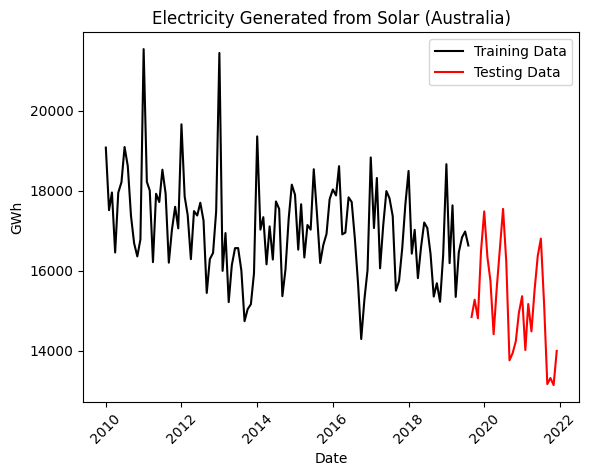

In [45]:
# Plot data
plt.plot(train['date'],train['non_renews'], color = "black", label= "Training Data")
plt.plot(test['date'],test['non_renews'], color = "red", label= "Testing Data")
plt.ylabel('GWh')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Electricity Generated from Solar (Australia)")
plt.legend()
plt.show()

In [50]:
def line_plot(line1, line2, date1,date2,label1=None, label2=None, title='', lw=1):
  plt.plot(date1,line1, color = "black", label=label1)
  plt.plot(date2,line2, color = "red", label=label2)
  plt.ylabel('GWh')
  plt.xlabel('Date')
  plt.xticks(rotation=45)
  plt.title(title)
  plt.legend()
  plt.show()

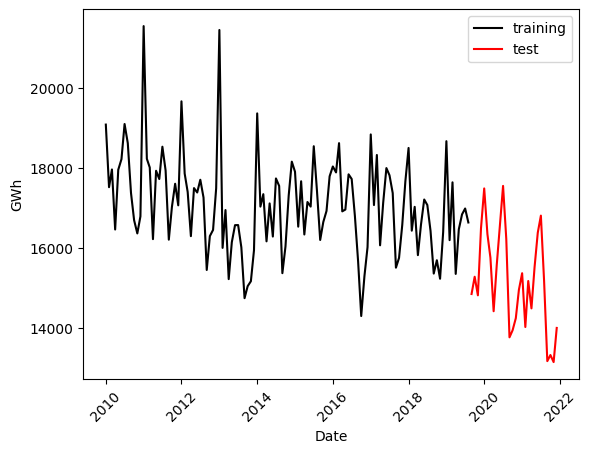

In [51]:
line_plot(train[target_col], test[target_col],train['date'],test['date'],'training', 'test', title='')

In [61]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [62]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [63]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [64]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [65]:
np.random.seed(144)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [66]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    aus_df_2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

TypeError: ignored

In [ ]:

# building input variable
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)

In [ ]:
# Set date parameters for train and test data
train = aus_df[aus_df.date < pd.to_datetime("2020-09-02", format='%Y-%m-%d')]
test = aus_df[aus_df.date >= pd.to_datetime("2020-09-02", format='%Y-%m-%d')]
validation = aus_df[aus_df.date >= pd.to_datetime("2021-01-01", format='%Y-%m-%d')]
time_step = 144
X_train, y_train = create_dataset(train, time_step)
X_test, ytest = create_dataset(test, time_step)
X_val, yval = create_dataset(validation, time_step)

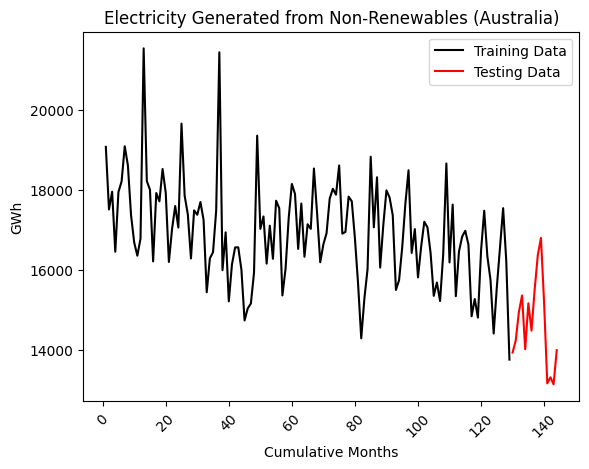

In [ ]:
# Plot data
plt.plot(train['cum_month'],train['non_renews'], color = "black", label= "Training Data")
plt.plot(test['cum_month'],test['non_renews'], color = "red", label= "Testing Data")
plt.ylabel('GWh')
plt.xlabel('Cumulative Months')
plt.xticks(rotation=45)
plt.title("Electricity Generated from Non-Renewables (Australia)")
plt.legend()
plt.show()

# Start of the LSTM Model Application

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 72, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 72, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 72, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 72))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')



In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 144, 72)           21312     
                                                                 
 dropout_2 (Dropout)         (None, 144, 72)           0         
                                                                 
 lstm_9 (LSTM)               (None, 144, 72)           41760     
                                                                 
 lstm_10 (LSTM)              (None, 144, 72)           41760     
                                                                 
 lstm_11 (LSTM)              (None, 72)                41760     
                                                                 
 dense_2 (Dense)             (None, 1)                 73        
                                                                 
Total params: 146,665
Trainable params: 146,665
Non-tr

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
step_size = 1
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [ ]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad', run_eagerly=True) # Try SGD, adam, adagrad and compare!!!
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)

Epoch 1/5


ValueError: ignored

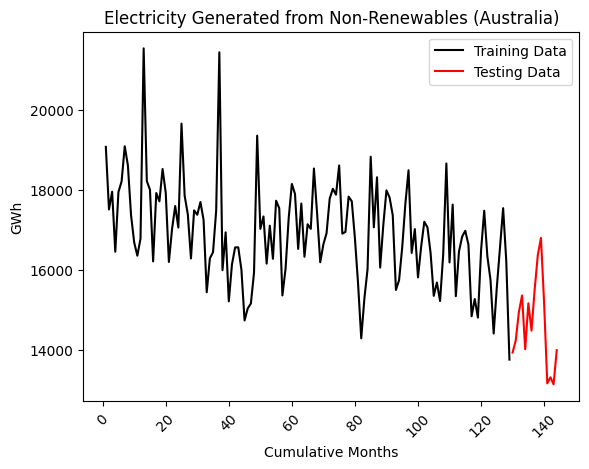

In [ ]:
# Set date parameters for train and test data
train = aus_df[aus_df.date < pd.to_datetime("2020-09-02", format='%Y-%m-%d')]
test = aus_df[aus_df.date >= pd.to_datetime("2020-09-02", format='%Y-%m-%d')]

# Plot data
plt.plot(train['cum_month'],train['non_renews'], color = "black", label= "Training Data")
plt.plot(test['cum_month'],test['non_renews'], color = "red", label= "Testing Data")
plt.ylabel('GWh')
plt.xlabel('Cumulative Months')
plt.xticks(rotation=45)
plt.title("Electricity Generated from Non-Renewables (Australia)")
plt.legend()
plt.show()

In [ ]:
y=train['non_renews']

In [ ]:
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)

In [ ]:
training_size = int(len(y)*0.80)
test_size = len(y)- training_size
val_size = int(training_size*0.20)
train_data , test_data , val_data = y[0:training_size-val_size,:] , y[training_size:len(y),:1], y[len(y)-test_size-val_size:len(y)-test_size,:1]

KeyError: ignored

In [ ]:
# building input variable
def create_dataset(dataset, time_step = 1):
  dataX, dataY = [] , []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)

NameError: ignored

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (time_step, 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# # Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

NameError: ignored

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_val,yval), verbose = 1,epochs = 60 ,batch_size = 20)

NameError: ignored